In [ ]:
import kutils
from kutils import model_helper as mh
from kutils import applications as apps
from kutils import image_utils as iu
from kutils import tensor_ops as ops
import pandas as pd

### KonCept512 model
3 fully-connected layers + dropouts on top of the Global Average Pooled features from InceptionResNet-v2

In [ ]:
aux_root = '/mnt/home/research/data/'
data_root = '/mnt/home/research/koniq/'
ids = pd.read_csv(data_root + 'metadata/koniq10k_distributions_sets.csv')

from keras.models import Model

# build scoring model
base_model, preprocess_fn = apps.get_model_imagenet(apps.InceptionResNetV2)
head = apps.fc_layers(base_model.output, name='fc', 
                      fc_sizes      = [2048, 1024, 256, 1], 
                      dropout_rates = [0.25, 0.25, 0.5, 0], 
                      batch_norm    = 2)    

model = Model(inputs = base_model.input, outputs = head)
print('[done]')

In [ ]:
# parameter of the generator
pre = lambda im: preprocess_fn(iu.ImageAugmenter(im, remap=False).fliplr().result)
gen_params = dict(batch_size  = 32, 
                  data_path   = data_root+'images/512x384/',
                  process_fn  = pre, 
                  input_shape = (384,512,3),
                  outputs     = ('MOS',))

# Wrapper for the model, helps with training and testing
helper = mh.ModelHelper(model, 'KonCept512', ids, 
                     loss='MSE', metrics=["MAE", ops.plcc_tf],
                     monitor_metric = 'val_loss', 
                     monitor_mode   = 'min', 
                     multiproc   = True, workers = 5,
                     logs_root   = aux_root + 'logs/koniq',
                     models_root = aux_root + 'models/koniq',
                     gen_params  = gen_params)

print '[done]'

#### Train model

In [ ]:
helper.train(lr=1e-4, epochs=40)
helper.load_model()
helper.train(lr=1e-4/5, epochs=20)
helper.load_model()
helper.train(lr=1e-4/10, epochs=10)

#### Test
this section can be run by loading the pretrained model on KonIQ-10k

Model weights loaded: /mnt/home/research/koniq/models/KonCept512/bsz32_i1[384,512,3]_lMSE_o1[1]_best_weights.h5
Testing model
Model outputs: ['fc_out']

Evaluated on test-set
SRCC/PLCC: 0.918 0.933


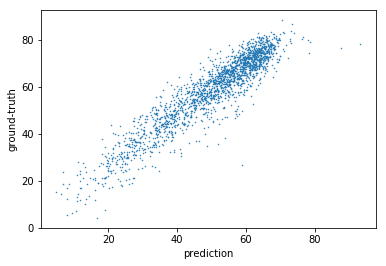

In [6]:
model_name = data_root + 'models/KonCept512/bsz32_i1[384,512,3]_lMSE_o1[1]'
# uncomment to use the in-memory model
# model_name = ''
if helper.load_model(model_name=model_name):
    apps.test_rating_model(helper);